# Wannier functions in trivial Haldane model

In [1]:
from pythtb import Mesh, Wannier, WFArray
from pythtb.models import haldane
import numpy as np

## Haldane model

Setting up `pythTB` tight-binding model for the Haldane model parameterized by the onsite potential $\Delta$, nearest neighbor hopping $t_1$ and complex next nearest neighbor hopping $t_2$

In [2]:
# tight-binding parameters
delta = t1 = 1
t2 = -0.1
n_super_cell = 2  # number of primitive cells along both lattice vectors

model = haldane(delta, t1, t2).make_supercell([[n_super_cell, 0], [0, n_super_cell]])

## `Wannier` class

The `Wannier`class contains the functions relevant for subspace selection, maximal-localization, and Wannier interpolation. We initialize it by passing the reference `Model` and number of k-points along each dimension in the mesh.

In [3]:
nks = 20, 20 # number of k points along each dimension
mesh = Mesh(dim_k=2, axis_types=['k', 'k'])
mesh.build_grid(shape=nks)
mesh.loop_axis(0, 0)
mesh.loop_axis(1, 1)
print(mesh)

Mesh Summary
Type: grid
Dimensionality: 2 k-dim(s) + 0 λ-dim(s)
Number of mesh points: 400
Full shape: (20, 20, 2)
k-shape: (20, 20)
λ-shape: ()
k-axes: [0, 1]
λ-axes: []
Axis names: [k_0, k_1]
Endpoints included on axis: [◦, ◦]   (• yes, ◦ no/unknown)
Is a torus in k-space (all k-axes wrap): yes
Periodic axes: (axis 0 winds component 0), (axis 1 winds component 1)
Closed axes: None


In [4]:
wfa = WFArray(model, mesh)
wfa.solve_mesh()

In [5]:
WF = Wannier(model, wfa)

## Setting up trial wavefunctions 

Now we must choose trial wavefunctions to construct our Bloch-like states. A natural choice is delta functions on the low-energy sublattice in the home cell. 

The trial wavefunctions are defined by lists of tuples specifying the trial wavefunction's probability amplitude over the orbitals `[(n, c_n), ...]`. 

$$ |t_i \ \rangle = \sum_n c_n |\phi_n\rangle $$


_Note_: Normalization is handled internally so the square of the amplitudes do not need to sum to $1$. Any orbitals not specified are taken to have zero amplitude.

In [6]:
# model specific constants
n_orb = model.norb  # number of orbitals
n_occ = int(n_orb/2)  # number of occupied bands (assume half-filling)
low_E_sites = np.arange(0, n_orb, 2)  # low-energy sites defined to be indexed by even numbers

# defining the trial wavefunctions
tf_list = [ [(orb, 1)] for orb in low_E_sites] 
n_tfs = len(tf_list)

print(f"Trial wavefunctions: {tf_list}")
print(f"# of Wannier functions: {n_tfs}")
print(f"# of occupied bands: {n_occ}")
print(f"Wannier fraction: {n_tfs/n_occ}")

Trial wavefunctions: [[(np.int64(0), 1)], [(np.int64(2), 1)], [(np.int64(4), 1)], [(np.int64(6), 1)]]
# of Wannier functions: 4
# of occupied bands: 4
Wannier fraction: 1.0


In [7]:
WF.set_trial_wfs(tf_list)
WF.trial_wfs

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]])

In [8]:
WF.num_twfs

4

## Projection step

To obtain the initial Bloch-like states from projection we call the method `optimal_alignment` providing the trial wavefunctions we specified and the band-indices to construct Wannier functions from. This performs the operations,
1. Projection $$ (A_{\mathbf{k}})_{mn} = \langle \psi_{m\mathbf{k}} | t_n \rangle$$
2. SVD $$ A_{\mathbf{k}} = V_{\mathbf{k}} \Sigma_{\mathbf{k}} W_{\mathbf{k}}^{\dagger} $$
3. Unitary rotation$$ |\tilde{\psi}_{n\mathbf{k}} \rangle = \sum_{m\in \text{band idxs}} |\psi_{m\mathbf{k}} \rangle (V_{\mathbf{k}}W_{\mathbf{k}}^{\dagger})_{mn} $$
4. Fourier transformation $$  |\mathbf{R} n\rangle = \sum_{\mathbf{k}} e^{-i\mathbf{k}\cdot \mathbf{R}} |\tilde{\psi}_{n\mathbf{k}} \rangle  $$

In [9]:
WF.optimal_alignment(band_idxs=list(range(n_occ)))

Setting tilde states...


This will already gives us quite localized Wannier functions. We can see their spreads by calling the function `report`.

In [10]:
WF.report()

Wannier function report
 --------------------- 
Quadratic spreads:
w_0 --> 0.10437
w_1 --> 0.10437
w_2 --> 0.10437
w_3 --> 0.10437
Centers:
w_0 --> [0.5     0.28868]
w_1 --> [1.     1.1547]
w_2 --> [1.5     0.28868]
w_3 --> [2.     1.1547]
Omega_I = 0.3723288655936301
Omega_D = 0.004015730767240314
Omega_OD = 0.04114648120894767


We can also directly access the attributes

In [11]:
print(WF.spread)
print(WF.Omega_I)
print(WF.Omega_D)
print(WF.Omega_OD)
print(WF.centers)

omega_tilde_ss = WF.Omega_OD + WF.Omega_D

[0.10437277 0.10437277 0.10437277 0.10437277]
0.3723288655936301
0.004015730767240314
0.04114648120894767
[[0.5        0.28867513]
 [1.         1.15470054]
 [1.5        0.28867513]
 [2.         1.15470054]]


We can visualize the Wannier density using `plot_density`. We specify which Wannier function to look at with `Wan_idx`.

(<Figure size 640x480 with 1 Axes>, <Axes: >)

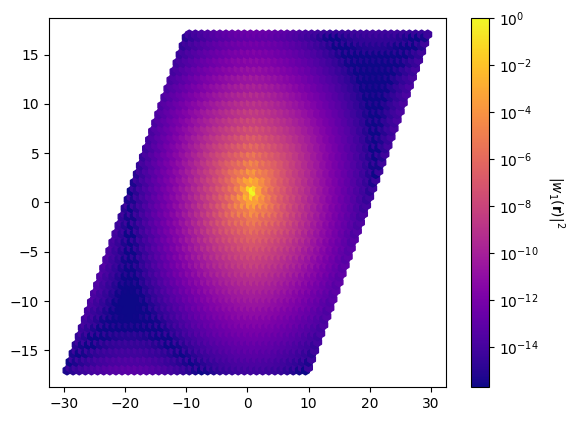

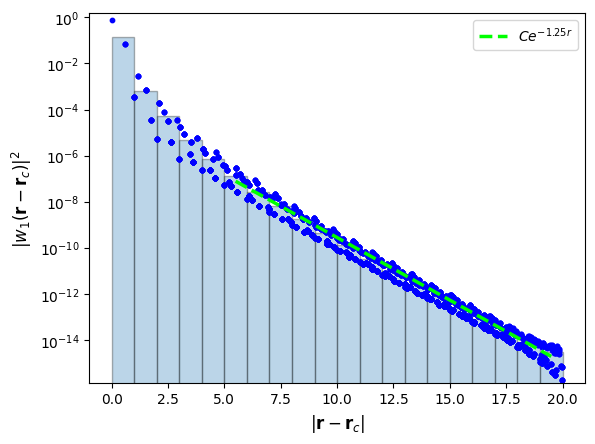

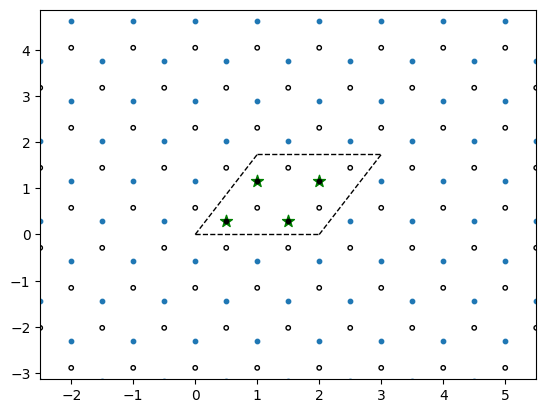

In [12]:
WF.plot_density(wan_idx=1)
WF.plot_decay(wan_idx=1, fit_rng=[5,20])
WF.plot_centers()

## Maximal Localization

_Maximal localization_ finds the optimal unitary rotation that minimizes the gauge dependent spread $\widetilde{\Omega}$ using the Marzari-Vanderbilt algorithm from PhysRevB.56.12847. 

To do so we call the `max_loc` function, specifying the following
- `eps` is the step size for gradient descent
- `iter_num` is the number of iterations before the calculation stops
- Optionally we can set `tol` specifying the minimum change in the spread at subsequent iterations before convergence
- For additional control we specify `grad_min` which sets the minimum gradient of the spread before convergence.

In [13]:
iter_num = 1000

WF.max_localize(eps=1e-3, iter_num=iter_num, tol=1e-10, grad_min=1e-10, verbose=True)

0 Omega_til = 0.04513289709239341, Grad mag: 13.967154388064253
1 Omega_til = 0.04510442583508146, Grad mag: 13.88413168093623
2 Omega_til = 0.04507675273204416, Grad mag: 13.801599922862906
3 Omega_til = 0.0450498365608322, Grad mag: 13.719556328014423
4 Omega_til = 0.045023639758960704, Grad mag: 13.637998118257112
5 Omega_til = 0.04499812794214337, Grad mag: 13.556922523944676
6 Omega_til = 0.044973269506706666, Grad mag: 13.476326784600236
7 Omega_til = 0.04494903529747731, Grad mag: 13.396208149506423
8 Omega_til = 0.04492539832856453, Grad mag: 13.316563878216702
9 Omega_til = 0.04490233354620921, Grad mag: 13.237391240999266
10 Omega_til = 0.04487981762595944, Grad mag: 13.158687519223207
11 Omega_til = 0.04485782879836667, Grad mag: 13.080450005694274
12 Omega_til = 0.04483634669739722, Grad mag: 13.002676004947277
13 Omega_til = 0.04481535222911701, Grad mag: 12.92536283350038
14 Omega_til = 0.044794827456088, Grad mag: 12.84850782007625
15 Omega_til = 0.044774755496278455, Gr

Now let's see how the localization improved.

In [15]:
WF.report()

omega_tilde_ml = WF.Omega_OD + WF.Omega_D
print()
print(f"Spread lowered by: {omega_tilde_ss-omega_tilde_ml}")

Wannier function report
 --------------------- 
Quadratic spreads:
w_0 --> 0.10396
w_1 --> 0.10396
w_2 --> 0.10396
w_3 --> 0.10396
Centers:
w_0 --> [0.5     0.28868]
w_1 --> [1.     1.1547]
w_2 --> [1.5     0.28868]
w_3 --> [2.     1.1547]
Omega_I = 0.37232886559462486
Omega_D = 0.003960229502700035
Omega_OD = 0.039564362878756684

Spread lowered by: 0.0016376195947312641
